#### Workshop Description
Understanding the questions posed by instructors and students alike plays an important role in the development of educational technology applications. In this intermediate level workshop, you will learn to apply NLP to one piece of this real-world problem by building a model to predict the type of answer (e.g. entity, description, number, etc.) a question elicits. Specifically, you will learn to:
1. Perform preprocessing, normalization, and exploratory analysis on a question dataset,
2. Identify salient linguistic features of natural language questions, and
3. Experiment with different feature sets and models to predict the answer type.
4. Use powerful pretrained language models to create dense sentence representations and apply deep learning models to text classification.

The concepts will be taught using popular NLP and ML packages like SpaCy, Scikit Learn, and Tensorflow.

This workshop assumes familiarity with Jupyter notebooks and the basics of scientific packages like numPy and sciPy. We also assume some basic knowledge of machine learning and deep learning techniques like CNNs, LSTMs, etc. Reference materials will be provided to gain a better understanding of these techniques for interested attendees.
***

# Feature Extraction & Classification

This notebook is the 2nd of 3 for the Course Hero ODSC workshop "Applications of NLP in EdTech." In this notebook, we will 
1. Extract important features from TREC question-classification text, 
2. Train and evaluate a Maximum Entropy classification model using these features, and 
3. Analyze the impact of each described featureset on the model's performance.

The model we build here is decent, but there is still a lot that can be done to improve it. Treat this a challenge to take what we cover here and expand it on your own to try to get the best possible performance!

**(Spoiler Alert)** In the next module (Module 3), We will also show you how to use deep learning to outperform the model developed here.

In [231]:
from typing import Dict, Tuple, List, Union

get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [257]:
from os.path import exists, join
from download_data import main as download_trec_data
import pandas as pd
import requests
import spacy

nlp = spacy.load('en_core_web_md')

### Download Data

First let's download the train and test data from Xin Li, Dan Roth, Learning Question Classifiers. COLING'02, Aug., 2002.
    <https://cogcomp.seas.upenn.edu/Data/QA/QC/">https://cogcomp.seas.upenn.edu/Data/QA/QC/>
    
We will store these data in Pandas DataFrames containing the following columns:
- *question*: The question text
- *processed_question*: The question as a SpaCy Doc object
- *coarse_label*: The coarse-grained label (6 classes)
- *label*: The fine-grained label

Recall that in Module 1, we found that some questions were duplicated. Let's remove those now.

In [8]:
if not exists("data"):
    download_trec_data()

path_to_train = join("data", "train.csv")
path_to_test = join("data", "test.csv")

train_df = pd.read_csv(join("data", "train.csv"))
test_df = pd.read_csv(join("data", "test.csv"))

#
# Dedupe from python module.
#
train_df = train_df.drop_duplicates("question")
test_df = test_df.drop_duplicates('question')

#
# Process questions with SpaCy
#
train_df['processed_question'] = train_df.question.apply(nlp)
test_df['processed_question'] = test_df.question.apply(nlp)


## Linguistic Features 

In [258]:
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as sw_1
from nltk import ngrams as NLTK_ngrams
from nltk.corpus import wordnet as wn

When we perform machine learning on text data, there are a number of different features that may prove valuable in learning how to distinguish between our classes.

Here, we break them down into "Syntactic Features" and "Semantic Features":

- ### Syntactic Features: 
Features that reflect the structure of our sentences.

1. **Word ngrams**: These are the length-n word sequences that occur in our data. The order of `n` can be anything, though typically high orders of `n` result in such sparse features that they are no longer very useful. We will experiment with a few different values and ranges of `n`, and ultimately settle on "unigrams" (single words), and "bigrams" (pairs of adjacent words).
  <u>Stopwords and Word ngrams</u>: Often, high-frequency words that serve a mostly functional purpose, eg. "of", "the", "from", are found to be of little help during text classification problems, and are thus removed from the text before ngram features are extracted. We can experiment with different sets of stopwords in our ngram-generation function.


  2. **Part-of-Speech ngrams**: The length-n sequences of syntactic classes (eg Noun, Verb, Preposition) can allow us to generalize key information about the language used in our data. Since the set of Part-of-Speech tags is significantly smaller than the number of unique words, this feature set is much less sparse than word n-grams and can help us find more general word-level patterns.


  3. **Dependency Triples**: Often, pairs of non-adjacent words, despite being located in different parts of a sentence, have a syntactic relationship. For example, in the two sentences below, the relationship between "What" and "say" can be characterized as one of "direct object" in both, despite their different word orderings. These relationships cannot be captured by n-grams, which only focus on groups of adjacent words. Instead, we can use SpaCy's powerful Universal Dependency parser to extract these relationships, and encode them as features. For details about Universal Dependency relationships, see <https://universaldependencies.org/>

> "What did Joanie say to Chachi?"

> "Joanie said what to Chachi??"



-----------
-----------

**Exercise**: There are a number of interesting variations on the features we define here, as well as many other features that may prove valuable for this task. Use what you know about the data to try implementing your own features (Write feature functions that return a dict mapping <feature_value_name> to 1). For example, you can try replacing one of the words in each dependency triple with its Part-of-Speech (in SpaCy, you can get `<token>.pos_`).

-------
-------

In [59]:
#
# Explore some different default stopword lists
#
print("SciKit-Learn stop words")
print(sorted(sw_1))
print("\n\n")
print("NLTK stop words")
from nltk.corpus import stopwords
sw_2 = stopwords.words('english')
print(sorted(sw_2))

print('\n\n')
print(set(sw_2).difference(sw_1))

SciKit-Learn stop words
['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full',

In [453]:
modified_question_stopwords = set([
    'a', 'about', 'above', 'after', 'again', 'against', 
    'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', 
    "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 
    'being', 'below', 'between', 'both', 'but', 'by', 'can', 
    'couldn', "couldn't", 'd', 'doing', 'don', "don't", 'down', 
    'during', 'each', 'few', 'for', 'from', 'further', 'had', 
    'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 
    'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 
    'herself', 'him', 'himself', 'his', 'i', 'if', 'in', 
    'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 
    'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 
    'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 
    'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once',
    'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 
    'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', 
    "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 
    'some', 'such', 't', 'than', 'that', "that'll", 'the', 
    'their', 'theirs', 'them', 'themselves', 'then', 'there', 
    'these', 'they', 'this', 'those', 'through', 'to', 'too', 
    'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 
    'we', 'were', 'weren', "weren't", 'while', 'with', 'won', 
    "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 
    "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'])

In [493]:
#
# Demonstrate dependency parses for two sentences with different 
# word orders.
#
doc1 = nlp("What did Joanie say to Chachi?")
doc2 = nlp(u"Joanie said what to Chachi??")


In [496]:
# spacy.displacy.serve(doc1, style='dep')


    Serving on port 5000...
    Using the 'dep' visualizer



127.0.0.1 - - [17/Oct/2019 10:38:45] "GET / HTTP/1.1" 200 4562
127.0.0.1 - - [17/Oct/2019 10:38:45] "GET /favicon.ico HTTP/1.1" 200 4562



    Shutting down server on port 5000.



In [495]:
# spacy.displacy.serve(doc2, style='dep')


    Serving on port 5000...
    Using the 'dep' visualizer



127.0.0.1 - - [17/Oct/2019 10:38:25] "GET / HTTP/1.1" 200 3821
127.0.0.1 - - [17/Oct/2019 10:38:25] "GET /favicon.ico HTTP/1.1" 200 3821



    Shutting down server on port 5000.



![dep_nobj-2](images/joanie-chachie-2.png)
![dep_nobj-1](images/joanie-chachie-1.png)

### Syntactic Feature Function Implementations

In [181]:
def word_ngrams(question: spacy.tokens.doc.Doc, 
                ngram_range: Tuple[int] = (1, 2), 
                stopwords: Union[List[str], None] = None, 
                lower: bool = False) -> Dict[str, int]:
    """
    Generate word n-grams for a piece of text. Use NLTK_ngrams(<List[str]>, n) 
    function to generate n-grams for order `n`.
    
    Parameters
    ----------
    question: spacy.tokens.doc.Doc
        A spacy Doc (ie a string that has been processed via eg `nlp(s)`)
        
    ngram_range: tuple of ints 
        A tuple of min and max n for ngrams.
        
    stopwords: List of str or None 
        List of words to exclude. For present purposes, when `n` > 1, only 
        exclude the ngram if all of its tokens are stopwords.
        
    lower: bool 
        A boolean indicating whether to lowercase the text in the ngrams.

    Returns
    -------
    dict
        Map of feature names to 1.
    """
    ngram_dict = {}    
    stopwords = (set([]) if stopwords is None 
                 else {w.lower() for w in stopwords})
    
    if lower:
        tokens = [t.text.lower() for t in question]
    else:
        tokens = [t.text for t in question]

    min_n, max_n = ngram_range
    for n in range(min_n, max_n + 1):
        ngrams_for_n = NLTK_ngrams(tokens, n)
        for ng in ngrams_for_n:
            if all(w in stopwords for w in ng):
                continue
            feature_key = "{}gram={}".format(n, " ".join(ng))
            ngram_dict[feature_key] = 1
    return ngram_dict

In [102]:
def pos_ngrams(question: spacy.tokens.doc.Doc, 
               ngram_range: Tuple[int] = (1, 2)
              ) -> Dict[str, int]:
    """
    Generate Part-of-speech n-grams for a piece of text. 
    Use NLTK_ngrams(<List[str]>, n) function to generate 
    n-grams for order `n`, and SpaCy's <token>.tag_ for detailed
    Part-of-Speech tags (alternatively you could try 
    <token>.pos_ for simple Part-of-Speech tags from the Universal 
    Part-of-Speech tag set.)
    
    Parameters
    ----------
    question: spacy.tokens.doc.Doc
        A spacy Doc (ie a string that has been processed via eg `nlp(s)`)
        
    ngram_range: tuple of ints 
        A tuple of min and max n for ngrams.
        
    Returns
    -------
    dict
        Map of feature names to 1.
        
    """
    ngram_dict = {}
    tokens = [t.tag_ for t in question]
    min_n, max_n = ngram_range
    for n in range(min_n, max_n + 1):
        for ng in NLTK_ngrams(tokens, n):
            feature_key = "POS_{}gram={}".format(n, " ".join(ng))
            ngram_dict[feature_key] = 1
    return ngram_dict

In [346]:
def dependency_triples(question: spacy.tokens.doc.Doc, 
                       lemmatize: bool = True
                      ) -> dict[(str, int)]:
    """
    Extract all (head, dependent, relation) dependency-triples for a 
    piece of text. Later, also substitute named entities with their type,
    or substitute either all heads or all dependents with their part of 
    speech.
    
    For each SpaCy token, `<token>.head` gives the text of the head token 
    for its dependency relationship, and `<token>.dep_` gives the relationship 
    type.
    
    To enable lemmatization of the tokens in the dependency triple, use 
    `<token>.lemma_`.
    
    Parameters
    ----------
    question: SpaCy Doc
        A question processed by a SpaCy model.
        
    lemmatize: bool
        Indicates whether or not to use the lemmas instead of the surface 
        token forms.
    
    Returns
    -------
    dict:
        A map of feature names to 1.
        
    """
    deps = {}
    for token in question:
        head, dependent, relation = token.head, token, token.dep_
        if relation == 'ROOT':
            continue
        #
        # If specified, replace the tokens with their lemmas.
        #
        if lemmatize:
            head = head.lemma_
            dependent = dependent.lemma_
        #
        # Otherwise, replace NE tokens with the NE type.
        #
        else:
            head = head.ent_type_ if head.ent_type_ else head
            dependent = dependent.ent_type_ if dependent.ent_type_ else dependent
            
        deps["dependencies#{}-{}-{}".format(head, dependent, relation).lower()] = 1
    return deps


- ### Semantic Features 
Features that focus on the meaning of word(s) or sentence(s).


  1. **Brown Cluster n-grams**: Brown clusters are a very useful grouping of words into classes based on their distributional information. Thus, words that occur frequently in similar contexts are more likely to be in the same class. This allows us to generalize word n-grams using distributional semantic similarity to reduce feature sparsity. For more details about brown clusters, see [the original paper](https://www.aclweb.org/anthology/J92-4003.pdf). Fortunately, SpaCy's "md" and "lg" pretrained models come with Brown Cluster assignments for all words in the vocabulary. You can access them with `<Token>.cluster`.
  
  
  2. **Named-Entity Types**: When Named Entities are present in a sentence, use the NE type (ie 'PERSON', 'ORG', etc) as a feature. See <a href="https://spacy.io/api/annotation#named-entities">This list</a> of all of the NE types identified with a pretrained SpaCy model.
  
  
  3. **Primary NP-Head Hypernyms**: Many "What" and "Who" questions ask about a specific Noun Phrase, which we will call "Primary". In the following two examples, I've underlined the "Primary" Noun chunk.

> "What <u>_ocean_</u> does Mauritania border"</em></p>

> "What is <u>the largest _lake_</u> in the United States?"

  In these examples, we should be able to detect that they are asking for the same answer type ('LOC'). One helpful technique is to use the Primary Noun Phrase head ("ocean" and "lake") both refer to places/bodies of water/physical entities. One nice way to do identify the similarities between these two NP heads is to use [WordNet](https://wordnet.princeton.edu/) for extraction the semantic relationships between the words.
  In this case, once we identify the head of the Primary Noun Phrase, we would like to generalize it to its <a href="https://en.wikipedia.org/wiki/Hyponymy_and_hypernymy">hypernyms</a>. One easy way to understand this is that a "hyponym" is a "type of" its hypernym. In the previous examples, both "lake" and "ocean" are types of "body of water", "physical entities", etc.</p>

As far as identifying the "primary Noun Phrase" and its "head", we can use some simple, mostly-accurate heuristics (see <a href="https://dl.acm.org/citation.cfm?id=1613835">Question classification using head words and their hypernyms</a> for detailed discussion of this technique and some more advanced approaches that could improve your model). For present purposes, we will use the following simple definition:

_The primary Noun Phrase of "What" (and some "Who") questions is the leftmost Noun chunk after the WH word. Its head is the right-most Noun in that chunk, ignoring Nouns embedded in Prepositional Phrases (The head Noun of "The picture of friend" would be "picture", not "friend")._

<h4> Semantic Feature Function Implementations </h4>

In [347]:
def brown_cluster_ngrams(question: spacy.tokens.doc.Doc, 
                         ngram_range: Tuple[int] = (1, 2)
                        ) -> dict[str, int]:
    """
    Generate Brown Cluster id n-grams for a piece of text. 
    
    Parameters
    ----------
    question: spacy.tokens.doc.Doc
        A spacy Doc (ie a string that has been processed via eg `nlp(s)`)
        
    ngram_range: tuple of ints 
        A tuple of min and max n for ngrams.
        
    Returns
    -------
    dict
        Map of feature names to 1.

    """
    ngram_dict = {}
    min_n, max_n = ngram_range
    cluster_id_tokens = [t.cluster for t in question]

    for n in range(min_n, max_n + 1):
        cluster_ngrams = NLTK_ngrams(cluster_id_tokens, n)
        for ng in cluster_ngrams:
            ngram_str = " ".join([str(i) for i in ng])
            feature_key = ("Cluster_{}gram={}".format(n, ngram_str))
            ngram_dict[feature_key] = 1
    return ngram_dict

In [348]:
def ne_types(question: spacy.tokens.doc.Doc) -> dict[str, int]:
    """
    Retrives the types of all of the named entities present in a given question.
    
    Parameters
    ----------
    question: SpaCy Doc 
        A question that has been processed via eg `nlp(<question_string>)`
    
    Returns
    -------
    dict
        Map of feature names to 1.

    """
    ents = {}
    for token in question:
        if token.ent_type_:
            ent_value = token.ent_type_
            ents['NE_type={}'.format(ent_value)] = 1
    return ents

In [350]:
#
# This cell contains all of the functions for generating the set of hypernyms for a 
# "primary" noun head in a "What" question.
#

def get_noun_hypernyms(word: str) -> List[str]:
    """
    Given a word, get the Noun hypernym synsets from WordNet (via nltk).
    
    Parameters
    ----------
    word: str
        The word for which we will return the synsets.
    
    Returns
    -------
    list of str
        All of Noun hypernyms for `word`.
        
    """
    return list({hypernym.name().split('.')[0] 
                 for synset in wn.synsets(word, 'n') 
                 for hypernym in get_hypernyms_from_synset(synset)})


def get_hypernyms_from_synset(synset: wordnet.Synset
                             ) -> Set[wordnet.Synset]:
    """
    Given a WordNet Synset, get all of its hypernymic synsets.
    
    Parameters
    ----------
    synset: nltk.corpus.reader.wordnet.Synset
        The synset for which we want the hypernymic synsets.
    
    Returns
    -------
    set of nltk.corpus.reader.wordnet.Synset
        All of the synsets in WordNet that are hypernyms of the 
        provided synset.
        
    """
    hypernyms = set()
    for hypernym in synset.hypernyms():
        hypernyms |= set(get_hypernyms_from_synset(hypernym))
    return hypernyms | set(synset.hypernyms())


def extract_primary_np_head(
    question: spacy.tokens.doc.Doc
) -> spacy.tokens.token.Token:
    """
    Find the "Primary Noun Head", as defined by our simple heuristic.
    Only try to extract if the provided question is a "What" question.
    
    Parameters
    ----------
    question: SpaCy Doc
        A question processed by a SpaCy model.
    
    Returns
    -------
    SpaCy Token
        The token object corresponding to the head of the primary Noun.
    """
    if question[0].text != 'What':
        return None
    noun_chunks = list(question.noun_chunks)
    if not noun_chunks:
        return None
    
    if len(noun_chunks[0]) > 1:  # is there more than 1 token in the first noun chunk?
        return noun_chunks[0][-1]
    elif len(noun_chunks) >= 2:
        primary_np = noun_chunks[1]
        return primary_np[-1]
        

def primary_np_head_hypernyms(
    question: spacy.tokens.doc.Doc
) -> dict[str, int]:
    """
    Identify the Primary NP's head token for "What" questions, 
    as defined by our simple heuristic above. Use SpaCy's `<doc>.noun_chunks`
    to get the noun chunks. In this case, we want to find either:
        1) the left-most token in the noun chunk immediately following 'What', or
        2) the Noun
        
    Parameters
    ----------
    question: SpaCy Doc
        A question processed by a SpaCy model.
    
    Returns
    -------
    dict
        Mapping from feature name to 1.
        
    """
    primary_np_head = extract_primary_np_head(question)
    if primary_np_head is None:
        return {}
    else:
        return {"PrimaryNPHeadHypernym={}".format(hyp): 1 
                for hyp in get_hypernyms(primary_np_head.text)}

In [1]:
def length(question: spacy.tokens.doc.Doc) -> dict[str, int]:
    """
    Get the number of chars to use as a feature. To convert to a binary 
    feature with limited sparsity, calculate the log(base2) of the number 
    of characters, and round the result to the nearest integer.
    
    """
    num_chars = len(str(question))
    binned_length = round(math.log(num_chars, 2))
    return {"log2charcount={}".format(binned_length): 1}

NameError: name 'spacy' is not defined

In [458]:
#
# Write Function to Extract All Features into a Single dict.
#
def create_full_feature_dict(question, feature_funcs_dict):
    feature_dict = {}
    for func, kwargs in feature_funcs_dict.items():
        feature_dict.update(func(question, **kwargs))
    return feature_dict

<h4>10-fold Cross-Validation Using Multinomial Logistic Regression </h4>
<br>
<div> 
    <p>Often, models are evaluated by training on one subset of the data, and predicting/evaluating on a held-out set. To improve on this technique, we can split all of our data into k subsets, and repeat the train/evaluate process k times, each time training on k-1 partitions and evaluating on the remaining partition. This gives us a lower-variance, higher-confidence performance estimate than simply evaluating on a single held out set. This process is known as <a href="https://www.cs.cmu.edu/~schneide/tut5/node42.html">cross-validation</a></p> 
    <p> We will perform 10-fold cross-validation, using the weighted <a href="https://en.wikipedia.org/wiki/F1_score">f1 score</a>, on multiple combinations of featuresets. Specifically, we will start with a single feature (word n-grams), and add featuresets one at a time to later evaluate the impact of each feature on model performance.
</div>

<p> We will use a Maximum Entropy (multinomial Logistic Regression) model as the classifier. The parameter values should provide good performance, but could likely be improved with Grid Search over the hyperparameter space.</p>

In [503]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import KFold

In [530]:
from collections import OrderedDict


all_feature_functions = OrderedDict({
    word_ngrams: {"lower": True},  #, "stopwords": modified_question_stopwords}, 
    pos_ngrams: {}, 
    dependency_triples: {'lemmatize': True}, 
    ne_types: {},
    brown_cluster_ngrams: {}, 
    primary_np_head_hypernyms: {}, 
    length: {}
})

In [531]:
f1_scores_dist = {}

In [551]:
def train_and_evaluate(train_X, train_y, test_X, test_y, print_report=False):
    """
    Train a Maximum Entropy model and calculate the f1 score on a test 
    partition. Optionally, print a classification report.
    """
    clf = LogisticRegression(C=100., fit_intercept=True, multi_class='auto')
    clf.fit(train_X, train_y)
    predictions = clf.predict(test_X)

    if print_report:
        print(classification_report(test_y, predictions))

    f1 = f1_score(test_y, predictions, average='weighted')        
    return f1, clf

In [533]:
n_splits = 10
seed = 12345
cv = KFold(n_splits=n_splits, random_state=seed)
folds_indeces = list(cv.split(train_df.index))

In [549]:
def xval_with_weighted_f1(folds, feature_functions):
    """
    Run cross-validation on `folds` folds, extracting features with the
    feature functions provided.
    
    Parameters
    ----------
    folds: int
        The number of folds.
    
    feature_functions: list of callable
        The feature functions that will be used to generate features for xval.
    
    Returns
    -------
    list of floats
        The weighted f1 score for each fold.
        
    """
    
    feature_vectorizer = DictVectorizer()
    scores = []
    
    feature_dict_func = lambda q: create_full_feature_dict(q, feature_functions)
    
    for i, (train_index, val_index) in enumerate(folds_indeces):
        train_rows = train_df.iloc[train_index]
        train_labels = train_rows.coarse_label
        train_questions = train_rows.processed_question
        train_feature_dicts = train_questions.apply(feature_dict_func)
        train_X = feature_vectorizer.fit_transform(train_feature_dicts)
        
        test_rows = train_df.iloc[val_index]
        test_labels = test_rows.coarse_label
        test_questions = test_rows.processed_question
        test_feature_dicts = test_questions.apply(feature_dict_func)
        test_X = feature_vectorizer.transform(test_feature_dicts)
        
        f1_score, clf = train_and_evaluate(train_X, train_labels, test_X, test_labels)
        scores.append(f1_score)
        
    return scores, (feature_vectorizer, clf)

In [553]:
#
# Calculate the f1-score for each fold of a variety of feature combinations.
#

featureset_score_tracker = {}
current_features_to_use = {}
feature_names = []
for feature_func, kwargs in all_feature_functions.items():
    current_features_to_use[feature_func] = kwargs
    feature_names.append(feature_func.__name__)
    experiment_name = "+".join([''.join([w[0] for w in n.split('_')]) for n in feature_names])
    weighted_f1_dist, (feature_vectorizer, clf) = xval_with_weighted_f1(10, 
                                                                        current_features_to_use)
    print("{}: {}".format(experiment_name, weighted_f1_dist))
    featureset_score_tracker[experiment_name] = weighted_f1_dist


wn: [0.8628849962552053, 0.8631634907644773, 0.8649527548361186, 0.8274297221669098, 0.8380589548800245, 0.8631718146755334, 0.8466408848029261, 0.8404857936151655, 0.8603165353953269, 0.8575088404777248]
wn+pn: [0.8744570043820968, 0.8427411198556561, 0.8607415116792495, 0.8265815611000281, 0.8233360702078997, 0.8549993533775466, 0.8352903126031398, 0.8522796358833894, 0.8297894824554047, 0.8628563307579346]
wn+pn+dt: [0.8782462735856625, 0.8644646740480391, 0.8696131222297446, 0.8533739965420035, 0.852310743544929, 0.8653912025075914, 0.8512884805393971, 0.8709277120561781, 0.8434353640643371, 0.8757039673675007]
wn+pn+dt+bcn: [0.8943484447912908, 0.8700143720048973, 0.8909654157475223, 0.8592272329679449, 0.8749030376070223, 0.8711208465302382, 0.8751031000211006, 0.8776925010056434, 0.8709391835086959, 0.883672388900548]
wn+pn+dt+bcn+pnhh: [0.9161012763518853, 0.9052070313356445, 0.883724833641303, 0.8829807876718234, 0.8933400145205462, 0.8965731844351457, 0.8884904933587222, 0.90

### Interpreting Coefficients
We can take the 10th fold of our most recent model (the one that used all of the features together), and which features the model found most impactful in the training data. We do this by using `<model>.coef_[i]`, where `i` is the index of the label of interest. The higher the coefficient value for a feature, the more impact it has on the final prediction. Below we list the top 20 features for each coarse-grained label.

In [555]:
for i, label in enumerate(('ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM')):
    top_features = sorted(list(zip(feature_vectorizer.get_feature_names(), 
                                   clf.coef_[i])), 
                          key=lambda t: t[1], 
                          reverse=True)[:20]
    print(label)
    for feature_name, weight in top_features:
        print("{}".format(feature_name))
    print('\n')

ABBR
Cluster_1gram=1957
dependencies#for-what-pobj
Cluster_2gram=762 0
PrimaryNPHeadHypernym=word
1gram=abbreviation
Cluster_2gram=0 0
PrimaryNPHeadHypernym=language_unit
dependencies#stand-do-aux
PrimaryNPHeadHypernym=part
Cluster_2gram=11 1957
2gram=stand for
Cluster_2gram=437 508
1gram=stand
Cluster_1gram=437
1gram=dtmf
2gram=dtmf ?
2gram=is dtmf
3gram=is dtmf ?
3gram=what is dtmf
4gram=what is dtmf ?


DESC
1gram=why
1gram=how
2gram=what is
dependencies#be-what-attr
Cluster_2gram=702 762
Cluster_1gram=3082
1gram=what
2gram=how does
POS_2gram=WRB VBP
2gram=how can
POS_2gram=WRB VBZ
dependencies#be-why-advmod
POS_1gram=WRB
dependencies#happen-what-nsubj
POS_2gram=WRB VBD
dependencies#cause-?-punct
PrimaryNPHeadHypernym=communication
1gram=mean
dependencies#make-what-nsubj
Cluster_1gram=31146


ENTY
1gram=what
Cluster_1gram=1145
PrimaryNPHeadHypernym=matter
1gram=animal
POS_1gram=WDT
2gram=what did
2gram=of ?
PrimaryNPHeadHypernym=creation
Cluster_2gram=11946 0
3gram=what does a
2gram

### Plot Cross-Validated F1-score for Different Featuresets

In [541]:
import matplotlib.pyplot as plt
%matplotlib inline

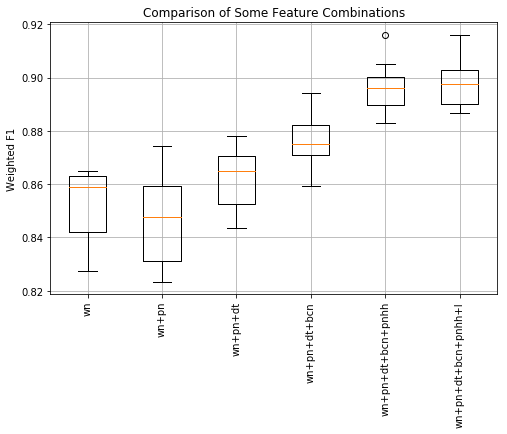

In [546]:
#
# Draw box-and-whisker plots to show the performances over all 10 folds for each 
# featureset combination.
#
labels = sorted(featureset_score_tracker.keys(), key=len)
fig = plt.figure(1, figsize=(8, 5))
ax = fig.add_subplot(111)
data_to_plot = [featureset_score_tracker[l] for l in labels]
ax.boxplot(data_to_plot)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("Weighted F1")
plt.title("Comparison of Some Feature Combinations")
plt.grid(True)
plt.show()

### Train on Entire Training Set and Evaluate on Heldout Data
Now that we have explored how our model performs on different folds of the training data, let's see how well it generalizes to the held-out test set.

In [552]:
feature_function = lambda q: create_full_feature_dict(q, all_feature_functions)

train_labels = train_df.coarse_label
train_questions = train_df.processed_question
train_feature_dicts = train_questions.apply(feature_function)
train_X = feature_vectorizer.fit_transform(train_feature_dicts)

test_labels = test_df.coarse_label
test_questions = test_df.processed_question
test_feature_dicts = test_questions.apply(feature_function)
test_X = feature_vectorizer.transform(test_feature_dicts)

_, _ = train_and_evaluate(train_X, train_labels, test_X, test_labels, print_report=True)

              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.91      0.99      0.95       138
        ENTY       0.86      0.83      0.84        94
         HUM       0.94      0.94      0.94        65
         LOC       0.95      0.93      0.94        81
         NUM       0.95      0.92      0.94       113

   micro avg       0.92      0.92      0.92       500
   macro avg       0.94      0.90      0.91       500
weighted avg       0.92      0.92      0.92       500



### What's Next?
There is still a lot you can do to improve the model's performance. For instance, you can
1. <u>Try creating conjunctive features</u>: In addition to adding multiple feature sets as we have done above, another thing you can do is try to find features that, when combined, make a new, more valuable feature. A simple example could be, instead of using one feature to represent a word form and another to represent its part-of-speech, try a conjunctive feature that contains both (eg instead of word unigram "say", and pos unigram "VB", you could make a single feature "say//VB"). 


2. <u> Explore/Combine different models </u>: There are so many ways to model the features we have extracted here. We had some success using a Maximum Entropy model, but you may get some interesting results by using a tree-based model instead. Ensemble methods, which use multiple classifiers to improve the final predictions, are also worth exploring here.

##### Resources
- Here is an older but valuable [paper](http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf) about the process of feature selection.
- [Ensemble Methods Overview](https://en.wikipedia.org/wiki/Ensemble_learning)
- [Here](https://www.researchgate.net/publication/220637945_From_symbolic_to_sub-symbolic_information_in_question_classification) is a great paper showing how far you can take linguistic feature engineering to achieve very high peformance on this task.


---

In the next module, we will cover how to use representation learning and pre-trained deep learning models as an alternative to the manual feature-engineering we did here. 